# <center>ARIMA applied to summer windspeed</center>

## 1) Load a season and test out which ARIMA model makes the most sense to apply
## 2) Then apply any models which are physically reasonable and perform best to a different summer season
## 3) basic verification/validation on how it performs

### Import libraries from ARIMA pune project

In [2]:
import numpy as np
import pandas as pd
import math
from scipy.stats import pearsonr

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import itertools
import warnings
warnings.filterwarnings('ignore')

### Filename

In [3]:
filename ='europlt_processed.csv'

### Data

#### Cleaned tower data from KNMI, Dutch meteorological service, with 10 minutes intervals of wind speed
#### KNMI wind speed and direction observations
#### Europlatform station
#### Lat: 51.9978 Lon: 3.275 z: 29m above mean sea level
#### inititally collected from https://dataplatform.knmi.nl/dataset/windggevens-1-0
#### fields - wind speed FF_10m_10 (m/s)
#### gust speed FF_SENSOR_10 (m/s)
#### wind direction: DDN_10 (degrees)

In [4]:
europlt_wind = pd.read_csv(filename, delimiter=',', header=9)
europlt_wind.head()

,Datetime,LOCATION,NAME,LATITUDE,LONGITUDE,ALTITUDE,FF_10M_10,DD_10,DDN_10,DD_STD_10,DDX_10,FF_SENSOR_10,Flag
0,01/04/2003 00:10,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.15,2.8079,150.5,3.1,3.3094,3.63,1
1,01/04/2003 00:20,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.65,3.2536,153.6,1.9,3.7015,4.06,1
2,01/04/2003 00:30,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.98,3.5478,156.8,1.9,3.9659,4.35,1
3,01/04/2003 00:40,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.18,3.7261,159.9,2.5,4.3032,4.72,1
4,01/04/2003 00:50,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.45,3.9668,164.0,2.8,4.5676,5.01,1


### Set as index the datatime component

In [5]:
europlt_wind.set_index('Datetime', inplace=True)
europlt_wind.head()

,LOCATION,NAME,LATITUDE,LONGITUDE,ALTITUDE,FF_10M_10,DD_10,DDN_10,DD_STD_10,DDX_10,FF_SENSOR_10,Flag
Datetime,,,,,,,,,,,,
01/04/2003 00:10,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.15,2.8079,150.5,3.1,3.3094,3.63,1
01/04/2003 00:20,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.65,3.2536,153.6,1.9,3.7015,4.06,1
01/04/2003 00:30,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.98,3.5478,156.8,1.9,3.9659,4.35,1
01/04/2003 00:40,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.18,3.7261,159.9,2.5,4.3032,4.72,1
01/04/2003 00:50,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.45,3.9668,164.0,2.8,4.5676,5.01,1


### Find June through August 2005. Use as input for finding 10 minute period simulation

([<matplotlib.axis.XTick at 0x7feb026b4fd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

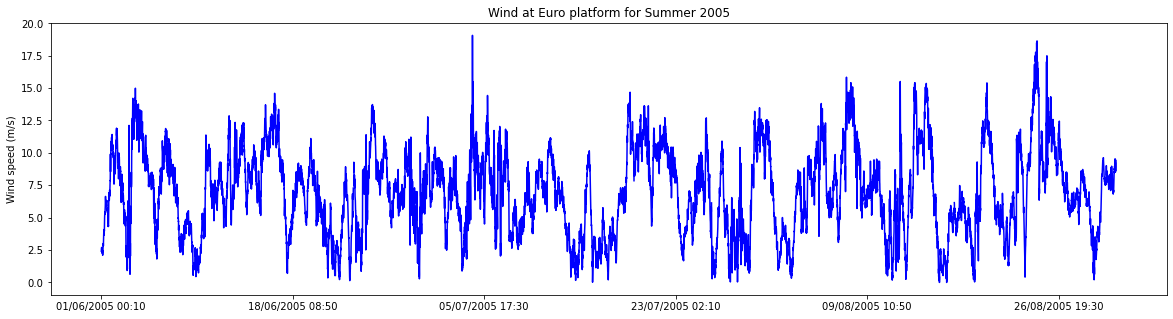

In [6]:
sum_winds = europlt_wind['01/06/2005 00:10':'31/08/2005 23:50']

wind_vals = sum_winds[["FF_10M_10"]].to_numpy()
flags = sum_winds[["Flag"]].to_numpy()

loc_flags = np.where(flags < 1)
wind_vals[loc_flags[0]] = float('NaN')

plt.figure(figsize=(20,5))
plt.plot(sum_winds.index, wind_vals, color='blue')
plt.title('Wind at Euro platform for Summer 2005')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 15000, step=2500))

### Find NaN Values in this timeseries

In [7]:
print(sum_winds.index[np.argwhere(flags<1)][:,0])

['01/06/2005 10:30' '02/06/2005 12:40' '07/06/2005 14:50'
 '07/06/2005 15:00' '08/06/2005 16:40' '08/06/2005 17:20'
 '08/06/2005 17:40' '08/06/2005 17:50' '12/06/2005 03:00'
 '13/06/2005 12:30' '13/06/2005 22:40' '23/06/2005 19:50'
 '23/06/2005 20:10' '23/06/2005 20:40' '23/06/2005 21:00'
 '23/06/2005 21:20' '24/06/2005 08:00' '26/06/2005 04:50'
 '26/06/2005 07:00' '05/07/2005 11:50' '09/07/2005 13:40'
 '19/07/2005 07:30' '19/07/2005 07:40' '19/07/2005 11:30'
 '24/07/2005 01:00' '24/07/2005 01:30' '26/07/2005 07:50'
 '26/07/2005 11:40' '04/08/2005 22:40' '17/08/2005 02:00'
 '17/08/2005 08:10' '19/08/2005 09:10' '21/08/2005 19:20'
 '21/08/2005 19:30' '27/08/2005 06:10' '29/08/2005 15:20'
 '31/08/2005 07:40' '31/08/2005 08:30' '31/08/2005 08:40'
 '31/08/2005 08:50' '31/08/2005 09:00' '31/08/2005 09:10']


array([   62,   219,   952,   953,  1107,  1111,  1113,  1114,  1601,
        1802,  1863,  3286,  3288,  3291,  3293,  3295,  3359,  3628,
        3641,  4966,  5553,  6956,  6957,  6980,  7637,  7640,  7966,
        7989,  9351, 11099, 11136, 11430, 11779, 11780, 12564, 12907,
       13149, 13154, 13155, 13156, 13157, 13158])

### No long periods of consistent NaN values like we found in December 2010 (ARIMA_tower_1month.ipynb). Should be good to apply this to for testing. 

### Need to check the stucture of the data for differencing, and then look at the ACF and Partial autocorrelation function. Should give us a starting point for which model to apply. 

In [8]:
sum_winds_d1 = np.diff(wind_vals[~np.isnan(wind_vals)])
sum_winds_d2 = np.diff(wind_vals[~np.isnan(wind_vals)], n=2)

dat_plot = []
dat_plot.append(wind_vals[0:20])
dat_plot.append(np.append(np.nan, sum_winds_d1[0:19]))
dat_plot.append(np.append([np.nan] * 2, sum_winds_d2[0:18]))
dat_plot

[array([[2.41],
        [2.49],
        [2.61],
        [2.7 ],
        [2.7 ],
        [2.68],
        [2.43],
        [2.49],
        [2.61],
        [2.55],
        [2.33],
        [2.33],
        [2.24],
        [2.28],
        [2.41],
        [2.45],
        [2.49],
        [2.26],
        [2.1 ],
        [2.24]]),
 array([  nan,  0.08,  0.12,  0.09,  0.  , -0.02, -0.25,  0.06,  0.12,
        -0.06, -0.22,  0.  , -0.09,  0.04,  0.13,  0.04,  0.04, -0.23,
        -0.16,  0.14]),
 array([  nan,   nan,  0.04, -0.03, -0.09, -0.02, -0.23,  0.31,  0.06,
        -0.18, -0.16,  0.22, -0.09,  0.13,  0.09, -0.09,  0.  , -0.27,
         0.07,  0.3 ])]

### No differencing

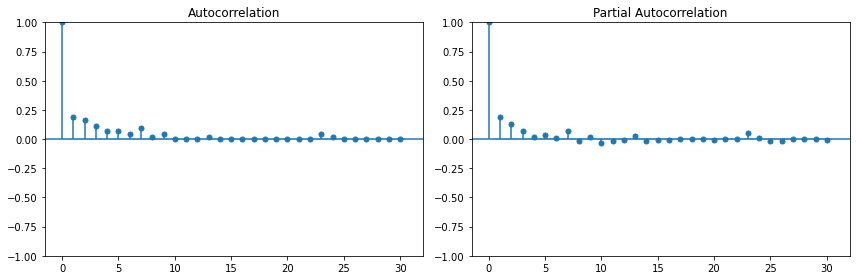

In [9]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(~np.isnan(wind_vals), lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(~np.isnan(wind_vals), lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

### first differencing

([<matplotlib.axis.XTick at 0x7feafa050dc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

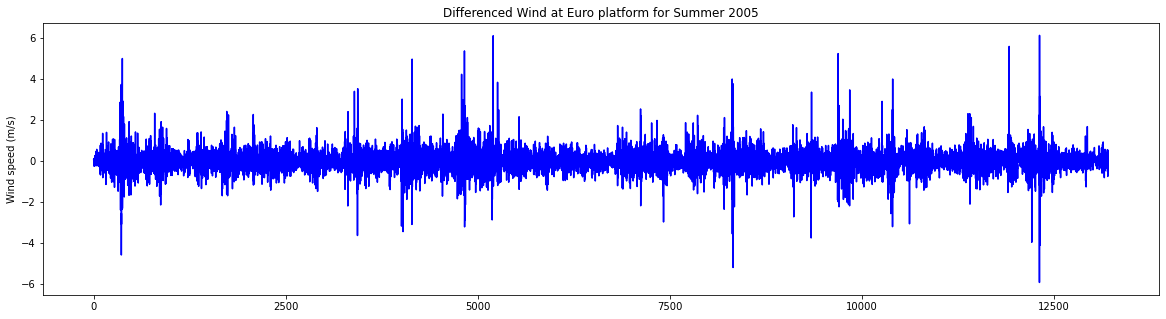

In [10]:
plt.figure(figsize=(20,5))
plt.plot(sum_winds_d1, color='blue')
plt.title('Differenced Wind at Euro platform for Summer 2005')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 15000, step=2500))

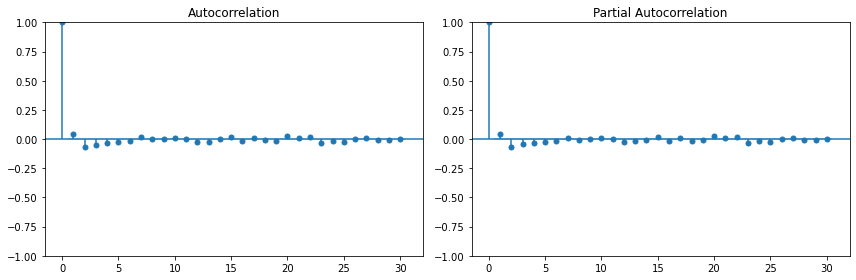

In [11]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sum_winds_d1, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sum_winds_d1, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

### Second differencing

([<matplotlib.axis.XTick at 0x7feaf9f25f10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

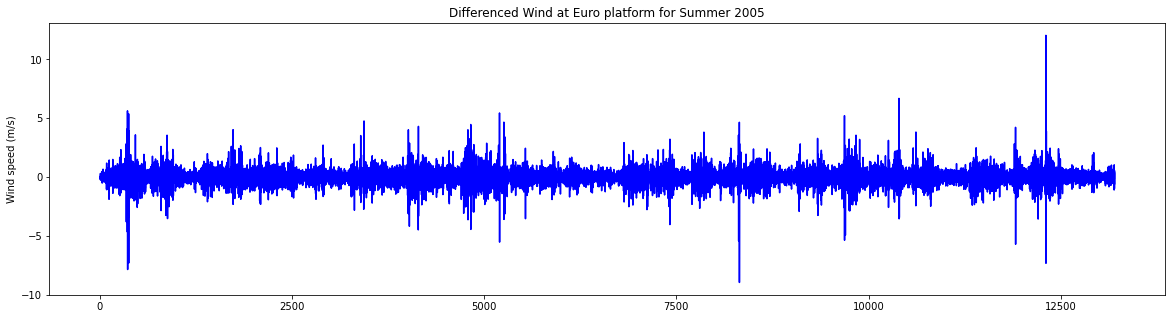

In [12]:
plt.figure(figsize=(20,5))
plt.plot(sum_winds_d2, color='blue')
plt.title('Differenced Wind at Euro platform for Summer 2005')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 15000, step=2500))

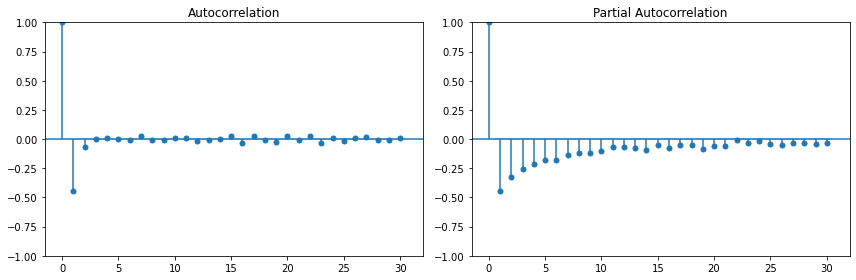

In [13]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sum_winds_d2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sum_winds_d2, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

### no structure in difference 1 model. Either use differencing 2 with (0,2,2) because the PCF trails off and the AR cuts off after lag 2 (See book Time Series Analysis and its applications by Shumway and Stoffer page 111). Or use a (p,0,q) as both tailing off. 

### based on PCF plot, p could be 3 at most whereas q could go out to 7

### first build dispersion model

In [89]:
disp_order = [2,0,2]
disp_model = sm.tsa.statespace.SARIMAX(wind_vals,
                                      order=disp_order,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
disp_results = disp_model.fit()
print(disp_results.summary().tables[0])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76312D-01    |proj g|=  7.15315D-03

At iterate    5    f=  7.76253D-01    |proj g|=  6.73800D-04

At iterate   10    f=  7.76135D-01    |proj g|=  4.26182D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   1.081D-05   7.761D-01
  F =  0.77612118073697922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                        

### Now build undispersive model with varying p and q.

In [15]:
# Define the p, d and q parameters to take any value across determined range

p = range(1, 3)
q = range(1, 10)

# Generate all different combinations of seasonal p, q and q triplets
pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]
pdq

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 0, 8),
 (1, 0, 9),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 6),
 (2, 0, 7),
 (2, 0, 8),
 (2, 0, 9)]

### apply AIC Criterion to work out which of these performs best

In [16]:
AIC_scores_list = []

best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:
        try:
            
            temp_model = sm.tsa.statespace.SARIMAX(wind_vals,
                                             order = param,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            l = []
            l.append(param[0])
            l.append(param[1])
            l.append(param[2])
            l.append(results.aic)
            AIC_scores_list.append(l)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
        except:
            continue

print("Best SARIMAX{} model - AIC:{}".format(best_pdq, best_aic))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80082D-01    |proj g|=  4.38328D-03

At iterate    5    f=  7.80074D-01    |proj g|=  1.10355D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.104D-05   7.801D-01
  F =  0.78007423832689660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.77912D-01    |proj g|=  2.92838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.858D-05   7.779D-01
  F =  0.77791175402422708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76534D-01    |proj g|=  5.97245D-03


 This problem is unconstrained.



At iterate    5    f=  7.76522D-01    |proj g|=  1.29786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   1.231D-05   7.765D-01
  F =  0.77652247338329450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76093D-01    |proj g|=  6.43788D-03

At iterate    5    f=  7.76085D-01    |proj g|=  3.21903D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      7      1     0     0   3.219D-05   7.761D-01
  F =  0.77608524797095790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.75955D-01    |proj g|=  4.43020D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   3.083D-05   7.760D-01
  F =  0.77595496624411520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75870D-01    |proj g|=  7.40793D-03


 This problem is unconstrained.



At iterate    5    f=  7.75859D-01    |proj g|=  3.52819D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6      8      1     0     0   2.905D-05   7.759D-01
  F =  0.77585948511453384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75713D-01    |proj g|=  8.10340D-03


 This problem is unconstrained.



At iterate    5    f=  7.75703D-01    |proj g|=  2.45670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6      9      1     0     0   1.836D-05   7.757D-01
  F =  0.77570340256595416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75714D-01    |proj g|=  8.25932D-03


 This problem is unconstrained.



At iterate    5    f=  7.75700D-01    |proj g|=  4.96354D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6      8      1     0     0   3.946D-05   7.757D-01
  F =  0.77569975789249679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75712D-01    |proj g|=  8.71906D-03


 This problem is unconstrained.



At iterate    5    f=  7.75695D-01    |proj g|=  4.40291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      7      9      1     0     0   5.178D-05   7.757D-01
  F =  0.77569507848889874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06918D+02    |proj g|=  4.02071D+02


 This problem is unconstrained.



At iterate    5    f=  1.38926D+00    |proj g|=  4.13330D-01

At iterate   10    f=  8.28133D-01    |proj g|=  8.00797D-02

At iterate   15    f=  7.81871D-01    |proj g|=  4.68629D-03

At iterate   20    f=  7.80512D-01    |proj g|=  1.09516D-03

At iterate   25    f=  7.80504D-01    |proj g|=  8.97137D-04

At iterate   30    f=  7.79930D-01    |proj g|=  1.58079D-02

At iterate   35    f=  7.79436D-01    |proj g|=  7.14045D-03

At iterate   40    f=  7.79299D-01    |proj g|=  2.60809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     50      1     0     0   8.032D-07   7.793D-01
  F =  0.779299057616

 This problem is unconstrained.



At iterate    5    f=  7.76253D-01    |proj g|=  6.73800D-04

At iterate   10    f=  7.76135D-01    |proj g|=  4.26182D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   1.081D-05   7.761D-01
  F =  0.77612118073697922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76075D-01    |proj g|=  5.02583D-03

At iterate    5    f=  7.76050D-01    |proj g|=  3.85267D-04

At iterate   10    f=  7.76024D-01    |proj g|=  2.55652D-03

At iterate   15    f=  7.76014D-01    |proj g|=  1.07079D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   1.071D-05   7.760D-01
  F =  0.77601351171434019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75952D-01    |proj g|=  6.43768D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4      7      1     0     0   3.473D-05   7.759D-01
  F =  0.77594753938152172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.7

 This problem is unconstrained.



At iterate    5    f=  7.75935D-01    |proj g|=  1.03644D-04

At iterate   10    f=  7.75935D-01    |proj g|=  1.23016D-03

At iterate   15    f=  7.75931D-01    |proj g|=  1.65777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     22      1     0     0   2.548D-05   7.759D-01
  F =  0.77593094396952145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75823D-01    |proj g|=  7.50627D-03

At iterate    5    f=  7.75803D-01    |proj g|=  5.07022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6      8      1     0     0   5.023D-05   7.758D-01
  F =  0.77580327627016310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75719D-01    |proj g|=  7.77980D-03

At iterate    5    f=  7.75710D-01    |proj g|=  2.99751D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6      8      1     0     0   2.024D-05   7.757D-01
  F =  0.77571009252859513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75715D-01    |proj g|=  8.24739D-03

At iterate    5    f=  7.75700D-01    |proj g|=  5.26373D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      7      9      1     0     0   5.465D-05   7.757D-01
  F =  0.77570013265758908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.75693D-01    |proj g|=  4.89948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      7      9      1     0     0   4.568D-05   7.757D-01
  F =  0.77569321868039520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best SARIMAX(1, 0, 7) model - AIC:20569.48594758239


### Compare best performing models

In [17]:
# add dispersion version to the table
dm = [0, 2, 2]
dm.append(disp_results.aic)
AIC_scores_list.append(dm)

AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
AIC_scores.columns=['p', 'd', 'q', 'AIC']
AIC_scores.iloc[AIC_scores['AIC'].argmin()]

AIC_scores.head(19)

,p,d,q,AIC
0,1,0,1,20673.286870
1,1,0,2,20617.994011
2,1,0,3,20583.186410
3,1,0,4,20573.602560
4,1,0,5,20572.150876
5,1,0,6,20571.621199
6,1,0,7,20569.485948
7,1,0,8,20571.389386
8,1,0,9,20573.265409
9,2,0,1,20654.749232


### little difference between 1,0,5 -> 1,0,9, although 1,0,7 performs best. The 2 0 models are all about the same, as is the 0,2,2. 

### Conclusion - use 1,0,7, but keep 0,2,2 for comparison. 

In [18]:
best_model = sm.tsa.statespace.SARIMAX(wind_vals,order=best_pdq)
best_results = best_model.fit()
print(best_results.summary().tables[0])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75713D-01    |proj g|=  8.10340D-03

At iterate    5    f=  7.75703D-01    |proj g|=  2.45670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6      9      1     0     0   1.836D-05   7.757D-01
  F =  0.77570340256595416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

### Now that we have our best and dispersion model, simulate a timeseries and compare. 

### NOTE: THIS IS NOT THE SAME AS PREDICT. Predict gives a mean value with confidence intervals, so it's just about the same as the previous wind value. Simulate gives you behaviour you're looking for

### load a test season first

([<matplotlib.axis.XTick at 0x7f9c4ff89610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

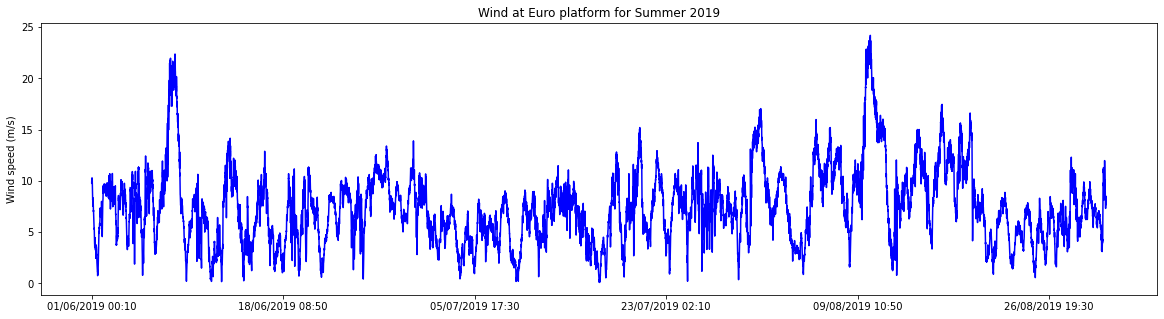

In [150]:
test_summer = europlt_wind['01/06/2019 00:10':'31/08/2019 23:50']

test_wind = test_summer[["FF_10M_10"]].to_numpy()
t_flags = test_summer[["Flag"]].to_numpy()

t_loc_flags = np.where(t_flags < 1)
test_wind[t_loc_flags[0]] = float('NaN')

plt.figure(figsize=(20,5))
plt.plot(test_summer.index, test_wind, color='blue')
plt.title('Wind at Euro platform for Summer 2019')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 15000, step=2500))

In [111]:
#check for huge gaps (multiple hours/days) in the timeseries.

print(test_summer.index[np.argwhere(t_flags<1)][:,0])
[np.argwhere(t_flags<1)]
#no consistent removal of points. 

['04/06/2019 12:10' '04/06/2019 12:20' '05/06/2019 13:30'
 '13/06/2019 17:00' '13/06/2019 17:10' '19/06/2019 00:00'
 '24/07/2019 07:00' '14/08/2019 12:50' '14/08/2019 13:10'
 '22/08/2019 10:50' '28/08/2019 18:50']


[array([[  504,     0],
        [  505,     0],
        [  656,     0],
        [ 1829,     0],
        [ 1830,     0],
        [ 2591,     0],
        [ 7673,     0],
        [10732,     0],
        [10734,     0],
        [11872,     0],
        [12784,     0]])]

## Find every point on the hour, hourly timeseries only

2207
13247
2207.8333333333335


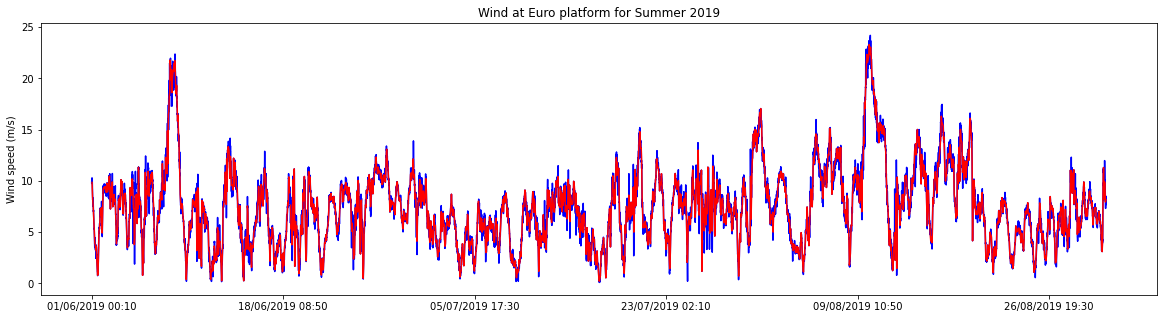

In [151]:
tsum_dates = test_summer.index[5::6]
tsum_vals = test_wind[5::6]

plt.figure(figsize=(20,5))
plt.plot(test_summer.index, test_wind, color='blue')
plt.plot(tsum_dates,tsum_vals,color='red')
plt.title('Wind at Euro platform for Summer 2019')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 15000, step=2500))

print(len(tsum_vals))
print(len(test_wind))
print(len(test_wind)/6)

## Apply the best model for this hourly data

In [113]:
t_model_best = sm.tsa.statespace.SARIMAX(tsum_vals,order=[1,0,7])
t_model_res = t_model_best.fit()
print(t_model_res.summary().tables[0])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66475D+00    |proj g|=  7.60431D-03



 This problem is unconstrained.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4      6      1     0     0   4.093D-05   1.665D+00
  F =   1.6646616802072978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2207
Model:               SARIMAX(1, 0, 7)   Log Likelihood               -3673.908
Date:                Sun, 01 May 2022   AIC                           7365.817
Time:                        18:48:28   BIC                           7417.111
Sample:                      

### For best model, simulate periods of 5 timesteps, looping through each timestep as an anchor. 

### Simulate 50 times, look at the statistics. 

In [232]:
#to append, first need to run step 1 of the loop
#need first anchor point to be 1 instead of 0 or causes instability issues (undiagnosed)
sim_list=np.zeros((5*len(tsum_vals[~np.isnan(tsum_vals)]),50))
for vers in range(0, 50):
    best_sim = t_model_res.simulate(5, anchor=1)
    dat_index = test_summer.index[0:5] 
    for sim in range(len(tsum_vals)):
        if ~np.in1d(sim,np.where(np.isnan(tsum_vals))):
            best_sim_vals=t_model_res.simulate(5, anchor=sim+1)
            best_sim = np.append(best_sim, best_sim_vals)
            dat_index = dat_index.append([test_summer.index[sim*6:sim*6+5]]) 
    sim_list[:,vers] = best_sim

In [236]:
#no wind speed values under zero. 
sim_list[np.where(sim_list<0)]=0

In [214]:
#find non-simulated values
tsum_real = europlt_wind.loc[dat_index,:]
tsum_real_wind = np.squeeze(tsum_real[["FF_10M_10"]].to_numpy())

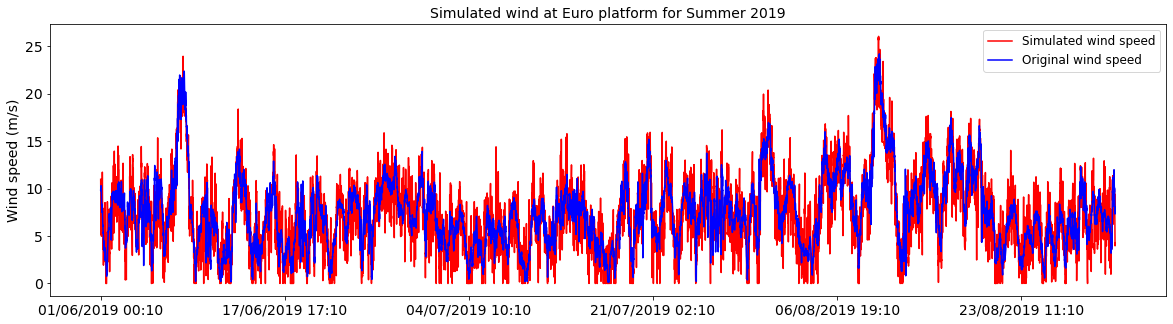

In [642]:
plt.figure(figsize=(20,5))
plt.plot(dat_index,sim_list[:,20],color='red',label='Simulated wind speed')
plt.plot(dat_index, np.squeeze(tsum_real_wind), color='blue',label='Original wind speed')
plt.title('Simulated wind at Euro platform for Summer 2019',fontsize=14)
plt.ylabel('Wind speed (m/s)',fontsize=14)
plt.xticks(np.arange(0, 12000, step=2000),fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=12)

In [377]:
r_squares = []
for x in range(50):
    r_squares.append(pearsonr(sim_list[~np.isnan(tsum_real_wind),x],tsum_real_wind[~np.isnan(tsum_real_wind)])[0]**2)
    
print(np.mean(r_squares))
pearsonr(np.mean(sim_list[~np.isnan(tsum_real_wind),:],axis=1),tsum_real_wind[~np.isnan(tsum_real_wind)])[0]**2

0.7249205588690947


0.9413319964087967

### Basic statistics and plots - scatter of the two

(array([ 0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

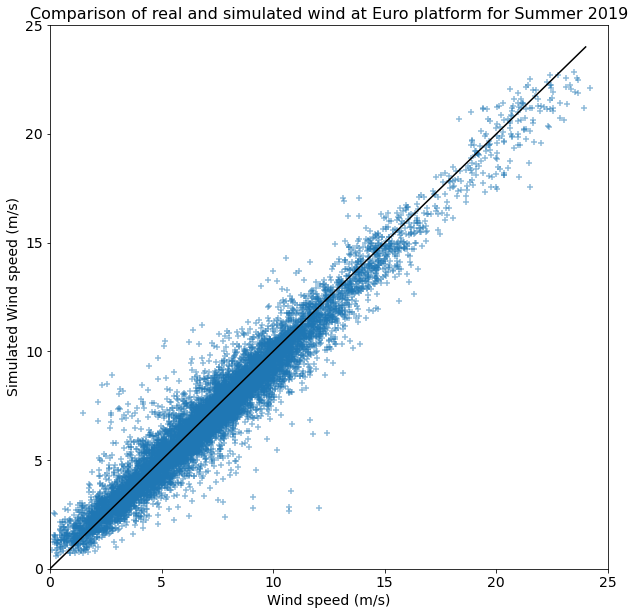

In [631]:
plt.figure(figsize=(10,10))
plt.scatter(tsum_real_wind, np.mean(sim_list,axis=1), marker='+',alpha=0.5)
plt.plot(np.arange(0,25,1),color='black')
#tried adding error bar of standard deviation, but too many points, too messy
#plt.errorbar(tsum_real_wind,np.mean(sim_list,axis=1),yerr=np.std(sim_list,axis=1),fmt="+")
plt.xlim(0,25)
plt.ylim(0,25)
plt.title('Comparison of real and simulated wind at Euro platform for Summer 2019',fontsize=16)
plt.ylabel('Simulated Wind speed (m/s)',fontsize=14)
plt.xlabel('Wind speed (m/s)',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

### compare distribution

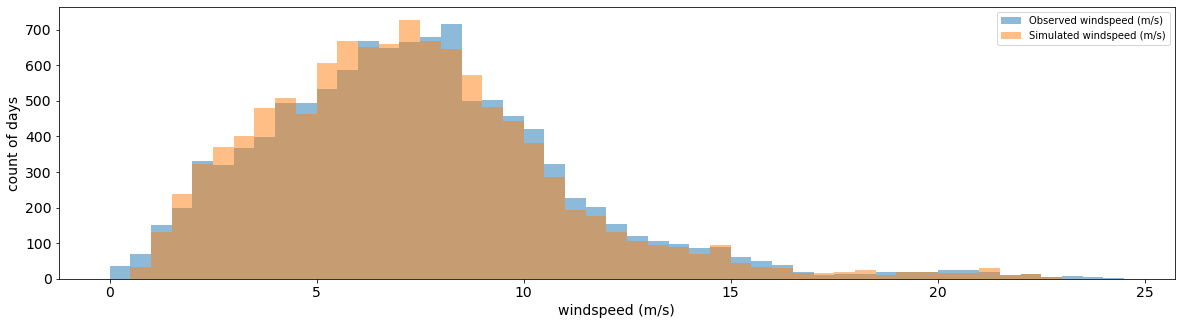

In [630]:
plt.figure(figsize=(20,5))
plt.hist(tsum_real_wind[~np.isnan(tsum_real_wind)],bins=np.arange(0,25,.5),alpha=0.5,label="Observed windspeed (m/s)")
plt.hist(np.mean(sim_list[~np.isnan(tsum_real_wind)],axis=1),bins=np.arange(0,25,.5),alpha=0.5,label="Simulated windspeed (m/s)",stacked='True')
plt.xlabel('windspeed (m/s)', size=14)
plt.ylabel('count of days', size=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc = 'upper right')

### for RMSE, variance, and Ramps/droughts want to look at multiple different summers to make sure the results aren't skewed by just one. 
### Loop over five summers 2010:2014
### this takes around 20 minutes, not efficiently coded. Recommend getting a cup of tea. 

In [357]:
# for the first variable in the list, put in the 2019 windspeed values you've already calculated
sim_test_years = (sim_list,)
#actual dates being simulated
sum_real_dates = (dat_index,)
#actual values being simulated
sum_real_vals = (tsum_real_wind,)

#define best model rather than hard coding
bmparams = [1,0,7]

#how many simulations?
nsims = 50

#loop through years
for year in range(2010,2015):
    start_date = f'01/06/{year} 00:10'
    end_date = f'31/08/{year} 23:50'
    rep_summer = europlt_wind[start_date:end_date]
    # find wind values and remove flagged issues
    rep_wind = rep_summer[["FF_10M_10"]].to_numpy()
    rep_flags = rep_summer[["Flag"]].to_numpy()
    rep_loc_flags = np.where(rep_flags < 1)
    rep_wind[rep_loc_flags[0]] = float('NaN')
    # run model
    trep_vals = rep_wind[5::6]
    trep_model_best = sm.tsa.statespace.SARIMAX(trep_vals,order=bmparams)
    trep_model_res = trep_model_best.fit()
    # preallocate the list of simulated values 
    rep_sim_list=np.zeros((5*len(trep_vals[~np.isnan(trep_vals)]),nsims))
    # loop over simulations
    for vers in range(0, nsims):
        trep_sim = trep_model_res.simulate(5, anchor=1)
        trep_dat_index = rep_summer.index[0:5] 
        for sim in range(len(trep_vals)):
            if ~np.in1d(sim,np.where(np.isnan(trep_vals))):
                rep_sim_vals=trep_model_res.simulate(5, anchor=sim+1)
                trep_sim = np.append(trep_sim, rep_sim_vals)
                trep_dat_index = trep_dat_index.append([rep_summer.index[sim*6:sim*6+5]]) 
        rep_sim_list[:,vers] = trep_sim
    #append values to lists    
    sim_test_years = (*sim_test_years, rep_sim_list)
    sum_real_dates = (*sum_real_dates, trep_dat_index)
    tsum_real = europlt_wind.loc[trep_dat_index,:]
    sum_real_vals = (*sum_real_vals,np.squeeze(tsum_real[["FF_10M_10"]].to_numpy()))
    print(year)



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58545D+00    |proj g|=  4.60229D-02

At iterate    5    f=  1.58394D+00    |proj g|=  3.82821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5      8      1     0     0   3.828D-05   1.584D+00
  F =   1.5839358823181746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2010


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60164D+00    |proj g|=  1.75536D-02

At iterate    5    f=  1.60125D+00    |proj g|=  1.06370D-04

At iterate   10    f=  1.60124D+00    |proj g|=  1.93459D-03

At iterate   15    f=  1.60123D+00    |proj g|=  1.21851D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     15     19      1     0     0   1.219D-05   1.601D+00
  F =   1.6012252817616610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2011
RUN

 This problem is unconstrained.


2012
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48142D+00    |proj g|=  1.28879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4      7      1     0     0   1.364D-05   1.481D+00
  F =   1.4812765401023527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2013
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37029D+00    |proj g|=  1.38900D-02


 This problem is unconstrained.



At iterate    5    f=  1.37008D+00    |proj g|=  1.25137D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5      8      1     0     0   1.251D-05   1.370D+00
  F =   1.3700826355363023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014


### You now have 2019, then 2010,2011,2012,2013,2014. Put 2019 at the end, chronological order

In [366]:
sum_real_ordered = [sum_real_vals[i] for i in [1,2,3,4,5,0]]
sum_sim_ordered = [sim_test_years[i] for i in [1,2,3,4,5,0]]
sum_dates_ordered = [sum_real_dates[i] for i in [1,2,3,4,5,0]]

### Now have values for six summers, 50 simulations each. Box plots of RMSE and Variance

Text(0, 0.5, 'Root Mean Square Error')

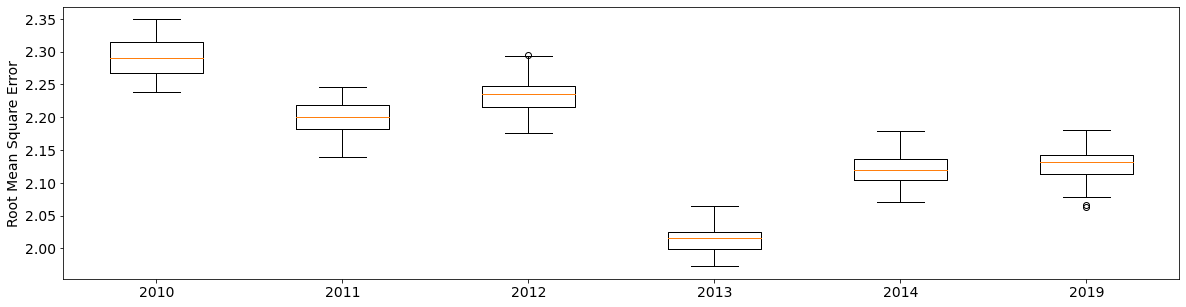

In [629]:
#For each year and all simulations, find RMSE
RMSE_vals=np.zeros((6,50))
for year_test in range(0,6):
    for sim_val in range(0,50):
        RMSE_vals[year_test,sim_val] = math.sqrt(np.nanmean(np.subtract(sum_real_ordered[year_test],sum_sim_ordered[year_test][:,sim_val])**2))

plt.figure(figsize=(20,5))
plt.boxplot(RMSE_vals.transpose())
plt.xticks([1,2,3,4,5,6],['2010','2011','2012','2013','2014','2019'],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Root Mean Square Error',fontsize=14)

In [384]:
#save in case of reboot
with open('sim_dates.npy','wb') as f:
     np.save(f,sum_dates_ordered)
#np.save(sim_dates,sum_dates_ordered)

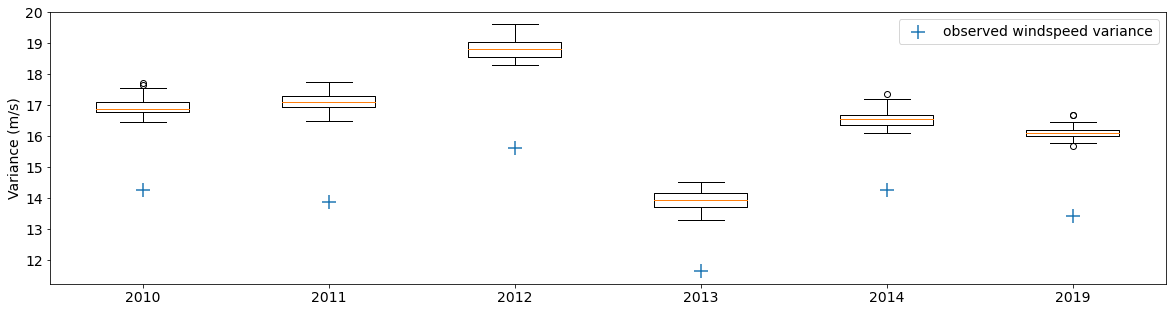

In [628]:
#bar char as above but for variance
obs_var = [np.nanvar(x) for x in sum_real_ordered]
sim_var = np.zeros((6,50))
for yr in range(0,6):
    for si in range(0,50):
        sim_var[yr,si] = np.nanvar(sum_sim_ordered[yr][:,si])
        
plt.figure(figsize=(20,5))
plt.scatter(np.arange(1,7), obs_var, s=200, marker='+',label='observed windspeed variance')
plt.boxplot(sim_var.transpose())
plt.xticks([1,2,3,4,5,6],['2010','2011','2012','2013','2014','2019'],fontsize=14)
plt.ylabel('Variance (m/s)',fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = 'upper right', fontsize=14)

## Examine periods of wind drought and wind ramps to assess performance 

### wind droughts - find running means at 1, 6, 24 and 72 hour periods. 

In [420]:
def running_mean(x, N):
    cumsum = np.nancumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [503]:
real_vals_hourly = [running_mean(x,6) for x in sum_real_ordered]
real_vals_6hr = [running_mean(x,36) for x in sum_real_ordered]
real_vals_daily = [running_mean(x,144) for x in sum_real_ordered]
real_vals_3d = [running_mean(x,432) for x in sum_real_ordered]

sim_vals_hourly = ()
sim_vals_6hr = ()
sim_vals_daily = ()
sim_vals_3d = ()

for yrrm in range(0,6):
    for sirm in range(0,50):
        sim_vals_hourly = (*sim_vals_hourly,running_mean(sum_sim_ordered[yrrm][:,sirm],6))
        sim_vals_6hr = (*sim_vals_6hr,running_mean(sum_sim_ordered[yrrm][:,sirm],36))
        sim_vals_daily = (*sim_vals_daily,running_mean(sum_sim_ordered[yrrm][:,sirm],144))
        sim_vals_3d = (*sim_vals_3d,running_mean(sum_sim_ordered[yrrm][:,sirm],432))


### Process for generating a graph of how many times ramps/droughts occur

### choose threshold to exceed (or be below in the case of a drought)

In [618]:
# a dumb loop to sort out my indexing and find the percentile across all years
A=sum_real_ordered[0]
for x in range(1,6):
    A=np.append(A,sum_real_ordered[x])
    
drought_thresh=np.nanpercentile(A,10)
drought_thresh

2.88

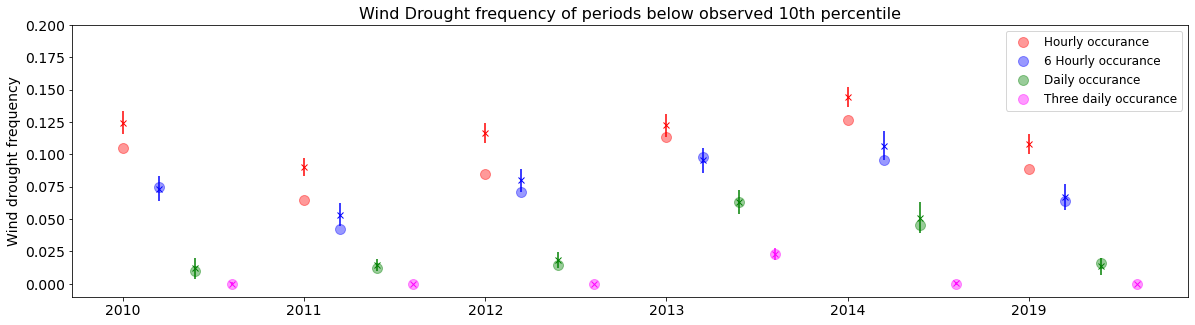

In [627]:
#choose percentile
thresh = drought_thresh
#change less than or more signs depending on if you are looking at ramps or droughts

true_thresh_hourly = [len(np.argwhere(real_vals_hourly[x]<thresh)) / len(real_vals_hourly[x]) for x in range(0,6)]
true_thresh_6hr = [len(np.argwhere(real_vals_6hr[x]<thresh)) / len(real_vals_6hr[x]) for x in range(0,6)]
true_thresh_daily = [len(np.argwhere(real_vals_daily[x]<thresh)) / len(real_vals_daily[x]) for x in range(0,6)]
true_thresh_3d = [len(np.argwhere(real_vals_3d[x]<thresh)) / len(real_vals_3d[x]) for x in range(0,6)]

#saved each simulation member as between 0 and 49, 50 to 99 etc.
sim_thresh_hourly = [len(np.argwhere(sim_vals_hourly[x]<thresh)) / len(sim_vals_hourly[x]) for x in range(0,300)]
sim_thresh_6hr = [len(np.argwhere(sim_vals_6hr[x]<thresh)) / len(sim_vals_hourly[x])  for x in range(0,300)]
sim_thresh_daily = [len(np.argwhere(sim_vals_daily[x]<thresh)) / len(sim_vals_hourly[x])  for x in range(0,300)]
sim_thresh_3d = [len(np.argwhere(sim_vals_3d[x]<thresh)) / len(sim_vals_hourly[x])  for x in range(0,300)]

plt.figure(figsize=(20,5))
plt.plot(np.arange(1,7),true_thresh_hourly,color='red',linewidth=0, marker='o',ms=10,label='Hourly occurance',alpha=.4)
plt.errorbar(np.arange(1,7),[np.nanmean(sim_thresh_hourly[x:(x+50)]) for x in range(0,300,50)],yerr=[1.5*np.nanstd(sim_thresh_hourly[x:(x+50)]) for x in range(0,300,50)],
             linewidth=1.5, color='red',fmt='x')

plt.plot(np.arange(1.2,7.2),true_thresh_6hr,color='blue',linewidth=0, marker='o',ms=10,label='6 Hourly occurance',alpha=.4)
plt.errorbar(np.arange(1.2,7.2),[np.nanmean(sim_thresh_6hr[x:(x+50)]) for x in range(0,300,50)],yerr=[1.5*np.nanstd(sim_thresh_6hr[x:(x+50)]) for x in range(0,300,50)],
             linewidth=1.5, color='blue',fmt='x')

plt.plot(np.arange(1.4,7.4),true_thresh_daily,color='green',linewidth=0, marker='o',ms=10,label='Daily occurance',alpha=.4)
plt.errorbar(np.arange(1.4,7.4),[np.nanmean(sim_thresh_daily[x:(x+50)]) for x in range(0,300,50)],yerr=[1.5*np.nanstd(sim_thresh_daily[x:(x+50)]) for x in range(0,300,50)],
             linewidth=1.5, color='green',fmt='x')

plt.plot(np.arange(1.6,7.6),true_thresh_3d,color='magenta',linewidth=0, marker='o',ms=10,label='Three daily occurance',alpha=.4)
plt.errorbar(np.arange(1.6,7.6),[np.nanmean(sim_thresh_3d[x:(x+50)]) for x in range(0,300,50)],yerr=[1.5*np.nanstd(sim_thresh_3d[x:(x+50)]) for x in range(0,300,50)],
             linewidth=1.5, color='magenta',fmt='x')
plt.title('Wind Drought frequency of periods below observed 10th percentile', fontsize=16)
plt.xticks([1,2,3,4,5,6],['2010','2011','2012','2013','2014','2019'],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Wind drought frequency',fontsize=14)
plt.ylim(-0.01,0.2)
plt.legend(loc = 'upper right', fontsize=12)

In [613]:
A=sum_real_ordered[0]
for x in range(1,6):
    A=np.append(A,sum_real_ordered[x]) 

(63105,)

### Just to see how long it takes, run the model on all the data. 

In [213]:
all_wind_vals = europlt_wind[["FF_10M_10"]].to_numpy()
all_flags = europlt_wind[["Flag"]].to_numpy()

loc_all_flags = np.where(all_flags < 1)
all_wind_vals[loc_all_flags[0]] = float('NaN')

t_model_all = sm.tsa.statespace.SARIMAX(all_wind_vals,order=best_pdq)
tma_fit = t_model_all.fit()
print(tma_fit.summary().tables[0])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94759D-01    |proj g|=  1.50751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4      6      1     0     0   4.386D-06   8.947D-01
  F =  0.89473560459295765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               989280
Model:               SARIMAX(1, 0, 7

### On VMI, Chugged through 989280 points in 226 seconds (3 minutes ish). No memory errors. 